In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image


# Задание 2. Свертки и базовые слои 
Это задание будет являться духовным наследником первого. 
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). 
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. 
Однако все элементы, которые вы будете реализовывать, достаточно просты.

In [2]:
class Layer:
    def __init__(self):
        self.param = None
    #def __repr__(self):
        # Функция, которая вызовется при print()
        
    def __call__(self, data):
        return data

## Задача 1. (2 балла)
Реализуйте слой BatchNorm (nn.BatchNorm). 
[Идея для вдохновления как всегода нашлась на хабре](https://habr.com/ru/articles/309302/)

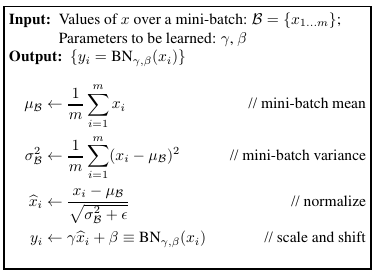

In [3]:
class BatchNorm(Layer):
    def __init__(self, len):
        self.w = torch.rand(len)
        self.b = torch.rand(len)
        self.param = [self.w, self.b]
    
    def __call__(self, data):
        return data

## Задача 2. (2 балла)
Реализуйте слой Linear (nn.Linear). 


In [4]:
class Linear(Layer):
    def __init__(self, input_len, output_len):
        self.W = torch.rand(input_len+1, output_len, requires_grad=True)
        self.param = [self.W]
    
    def __call__(self, X):
        X_1 = torch.ones(X.size()[1]).unsqueeze(0)
        X_con = torch.cat((X_1, X), 0)
        
        return self.W.T @ X_con
        
class Model:
    def __init__(self):
        ''' Набиваем модель слоями. Исполнение идет с лева на право: X------> '''
        self.layers = [Layer(), Layer(), Layer(), Layer()]

    def __call__(self, data):
        return self.forward(data)

    def parameters(self):
        parameters_arr = []

        for i in range(len(self.layers)):
            parameters_arr.append(self.layers[i].param)
        
        return parameters_arr
    
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x


В связи с тем, что передача в класс происходит по значению, а не по ссылки ``` optimizer = Optimizator(model.parameters(), lr=1e-3) ``` работало неверно, из-за чего пришлось захардкодить

In [5]:
'''
class Optimizator:
    def __init__(self, model_parameters, lr=0.001):
        self.model_parameters = model_parameters[::-1]
        self.lr = lr
    
    def zero_grad(self):
        # Тут мы сбрасывыем  градиенты в нуль 
        for i in range(len(self.model_parameters)):
            for j in range(len(self.model_parameters[i])):
                self.model_parameters[i][j].retain_grad()

    
    def step(self):
        # Тут мы коррентируем веса в соотвествии с SGD 
        for i in range(len(self.model_parameters)):
            for j in range(len(self.model_parameters[i])):
                print(self.model_parameters[i][j])
                self.model_parameters[i][j] = self.model_parameters[i][j] - self.lr * self.model_parameters[i][j].grad.data
'''

'\nclass Optimizator:\n    def __init__(self, model_parameters, lr=0.001):\n        self.model_parameters = model_parameters[::-1]\n        self.lr = lr\n    \n    def zero_grad(self):\n        # Тут мы сбрасывыем  градиенты в нуль \n        for i in range(len(self.model_parameters)):\n            for j in range(len(self.model_parameters[i])):\n                self.model_parameters[i][j].retain_grad()\n\n    \n    def step(self):\n        # Тут мы коррентируем веса в соотвествии с SGD \n        for i in range(len(self.model_parameters)):\n            for j in range(len(self.model_parameters[i])):\n                print(self.model_parameters[i][j])\n                self.model_parameters[i][j] = self.model_parameters[i][j] - self.lr * self.model_parameters[i][j].grad.data\n'

In [6]:
class MyModel(Model):
    def __init__(self):
        ''' Самая простая линейная модель '''
        self.layers = [Linear(1, 1)]

In [7]:
model = MyModel()
loss_fn = nn.MSELoss()

class Optimizator:
    def __init__(self, lr=0.001):
        #self.model_parameters = model_parameters[::-1]
        self.lr = lr
    
    def zero_grad(self):
        # Тут мы сбрасывыем  градиенты в нуль 
        for i in range(len(model.layers)):
            for j in range(len(model.layers[i].param)):
                #print("zero_grad1:", model.layers[i].param[j].grad)
                model.layers[i].param[j].grad = None
                #print("zero_grad2:", model.layers[i].param[j].grad)

    
    def step(self):
        # Тут мы коррентируем веса в соотвествии с SGD 
        for i in range(len(model.layers)):
            for j in range(len(model.layers[i].param)):
                print("step1:", model.layers[i].param[j])
                grad = model.layers[i].param[j].grad.data
                #print(grad)
                model.layers[i].param[j].data = model.layers[i].param[j].data - self.lr * grad
                #model.layers[i].param[j] = model.layers[i].param[j].clone().detach().requires_grad_(True)
#                print("step2:", model.layers[i].param[j])



optimizer = Optimizator(lr=1e-5)

In [8]:
x1 = torch.arange(-15, 15, 0.1)
x2 = torch.arange(-15, 15, 0.1) / 5
x = torch.stack([x1, x2], dim=1)
y = x[:,0] * 2. + 0.2 * x[:, 1]**2 - 3 + torch.normal(0., 0.2, (1, 300))
#plt.scatter(x[:, 0], y)

На второй итерации почему-то возникают сложности с подсчетом градиента 

In [9]:
for i in range(10000):
    preds = model(x[:, 0].unsqueeze(0))
    loss = loss_fn(preds, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.scatter(x[:, 0], y)
plt.scatter(x[:, 0], preds.detach().numpy())

AttributeError: 'Tensor' object has no attribute 'reset_grad'

## Задача 3. (2 балла)
Реализуйте слой Dropout(nn.Dropout)


## Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

## Задача 5. {*}. 
Вы получите по 1 дополнительному баллу за слой, 
если реализуете в рамках фреймворка из задания 3 прошлой работы


# Задание 2. {*} 3 балла
Реализуйте медианный фильтр. 
Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
сортируются, и выбирается медианное значение из отсортированного массива. 
Это значение и является выходным для текущего пикселя.
Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10


# Задание 3. 6 баллов
Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других.
При вызове метода __call__ он должен последовательно вызывать трансформации из списка.
При вызове каждого из них с вероятностью p должно 
применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное 
изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже.
Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

**torch.nn использовать нельзя!**

{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

# Задание 4. 3 балла
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
**В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
Проведите обучение на большом количестве эпох. 
Опишите, что вы наблюдаете для каждого случая и какая есть разница,
если применить трансформации.
Предоставьте графики в matplotlib или tensorboard (+1 балл) в 
ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами


# Задание 5. {*}  4 балла
Настройте проект в weights and biases, настройте логгинг туда из вашего цикла обучения (задание 4).
Выводите лосс и метрики на трейне и на тесте. Графики из задания 4 в таком случае можно выводить только туда.
Можете сохранять параметры обучения в качестве констант, и смотреть на сводную таблицу.
